In [92]:
import numpy as np
import pandas as pd

import itertools

import torch
import torch.nn as nn
import torch.optim as optim

from hypll import nn as hnn
from hypll.tensors import TangentTensor
from hypll.optim import RiemannianAdam
from hypll.manifolds.poincare_ball import Curvature, PoincareBall

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [93]:
import sys
sys.path.append('../')
import util

In [94]:
AROMA = ['A_malt_all', 'A_malt_grain', 'A_malt_bread', 'A_malt_cara',
'A_malt_burn', 'A_hops_all', 'A_hops_citrus', 'A_hops_tropical',
'A_hops_noble', 'A_hops_woody', 'A_esters_all', 'A_esters_ethac',
'A_esters_isoaa', 'A_esters_flower', 'A_esters_fruity']

FLAVOUR = ['F_malt_all', 'F_malt_grain', 'F_malt_bread', 'F_malt_cara',
'F_malt_burn', 'F_hops_all', 'F_hops_citrus', 'F_hops_tropical',
'F_hops_noble', 'F_hops_woody', 'F_esters_all', 'F_esters_ethac',
'F_esters_isoaa', 'F_esters_flower', 'F_esters_fruity']

BOTH = ['A_malt_all', 'A_malt_grain', 'A_malt_bread', 'A_malt_cara',
'A_malt_burn', 'A_hops_all', 'A_hops_citrus', 'A_hops_tropical',
'A_hops_noble', 'A_hops_woody', 'A_esters_all', 'A_esters_ethac',
'A_esters_isoaa', 'A_esters_flower', 'A_esters_fruity', 'F_malt_all',
'F_malt_grain', 'F_malt_bread', 'F_malt_cara', 'F_malt_burn',
'F_hops_all', 'F_hops_citrus', 'F_hops_tropical', 'F_hops_noble',
'F_hops_woody', 'F_esters_all', 'F_esters_ethac', 'F_esters_isoaa',
'F_esters_flower', 'F_esters_fruity']

REST = ['acidity', 'bitternes','sweetness', 'X4vg', 'diacetyl', 'dms',
'metallic', 'stale_hops', 't2n', 'orange', 'coriander', 'clove', 'lactic',
'acetic', 'barnyard', 'alcohol', 'aftertaste', 'body', 'co2', 'overall']

ALL = ['A_malt_all', 'A_malt_grain', 'A_malt_bread', 'A_malt_cara',
'A_malt_burn', 'A_hops_all', 'A_hops_citrus', 'A_hops_tropical',
'A_hops_noble', 'A_hops_woody', 'A_esters_all', 'A_esters_ethac',
'A_esters_isoaa', 'A_esters_flower', 'A_esters_fruity', 'F_malt_all',
'F_malt_grain', 'F_malt_bread', 'F_malt_cara', 'F_malt_burn',
'F_hops_all', 'F_hops_citrus', 'F_hops_tropical', 'F_hops_noble',
'F_hops_woody', 'F_esters_all', 'F_esters_ethac', 'F_esters_isoaa',
'F_esters_flower', 'F_esters_fruity', 'acidity', 'bitternes',
'sweetness', 'X4vg', 'diacetyl', 'dms', 'metallic', 'stale_hops', 't2n',
'orange', 'coriander', 'clove', 'lactic', 'acetic', 'barnyard',
'alcohol', 'aftertaste', 'body', 'co2', 'overall']

In [143]:
LABEL_COLS = ['overall']
# LABEL_COLS = ALL

In [144]:
# df_train_X = pd.read_csv('../data/beer_features_train_samples_small.csv', index_col=0)
# df_train_y = pd.read_csv('../data/beer_labels_panel_train_samples_small.csv', index_col=0)[LABEL_COLS]
df_train_X = pd.read_csv('../data/beer_features_train.csv', index_col=0)
df_train_y = pd.read_csv('../data/beer_labels_panel_train.csv', index_col=0)[LABEL_COLS]
df_val_X = pd.read_csv('../data/beer_features_train.csv', index_col=0)
df_val_y = pd.read_csv('../data/beer_labels_panel_train.csv', index_col=0)[LABEL_COLS]
df_test_X = pd.read_csv('../data/beer_features_test.csv', index_col=0)
df_test_y = pd.read_csv('../data/beer_labels_panel_test.csv', index_col=0)[LABEL_COLS]

train_X = df_train_X.values
train_y = df_train_y.values
val_X = df_val_X.values
val_y = df_val_y.values
test_X = df_test_X.values
test_y = df_test_y.values

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((175, 231), (175, 1), (175, 231), (175, 1), (75, 231), (75, 1))

In [145]:
df_train_y.columns

Index(['overall'], dtype='object')

In [136]:
df_train_y

,A_malt_all,A_malt_grain,A_malt_bread,A_malt_cara,A_malt_burn,A_hops_all,A_hops_citrus,A_hops_tropical,A_hops_noble,A_hops_woody,...,coriander,clove,lactic,acetic,barnyard,alcohol,aftertaste,body,co2,overall
6,-0.905714,-1.077875,-0.260900,-0.177046,-0.594063,-0.619652,0.044800,0.207679,-1.324545,-0.951525,...,-0.345755,-0.307440,-0.391769,-0.353104,-0.269106,1.041535,0.030754,0.421239,0.420907,0.716244
210,-1.373808,-1.213565,-0.596040,-0.571164,-0.594063,0.442864,0.739614,-0.712409,0.230288,0.649022,...,1.164256,0.351628,-0.391769,-0.353104,-0.269106,0.710811,-0.110804,-0.144940,2.049116,0.940569
32,0.766739,-0.756686,-0.409451,1.626618,-0.287994,-1.031041,-0.885848,-0.428902,-0.760801,-0.527575,...,-0.345755,-0.307440,-0.391769,-0.353104,1.837381,0.206458,0.571117,0.740761,-0.437480,0.176217
158,-0.573262,0.731325,-0.251961,-0.572992,-0.594063,-0.359812,0.359189,-0.712409,-0.773060,-0.103625,...,-0.345755,-0.307440,-0.391769,-0.353104,-0.661147,-0.412607,-0.391101,-1.244924,-0.714853,0.077218
137,0.676512,0.531307,-0.157330,1.102763,-0.574200,-0.579614,-0.561745,-0.406324,-0.374984,-0.859282,...,0.840491,-0.336036,-0.431918,-0.378765,-0.639774,-0.589746,-0.687158,-0.360927,-0.635707,-0.123924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,-0.960062,-0.788982,-1.135547,-0.541905,-0.232879,-0.257405,-0.391617,0.045742,-0.389976,-0.932278,...,-0.382524,0.213230,-0.431273,-0.376355,1.209752,-0.517570,-0.094346,-0.362296,-1.215982,0.805708
197,-0.918792,-0.395065,-0.948958,-0.377253,-0.585590,-0.636966,-0.900739,-0.690689,-0.422570,0.766905,...,-0.382524,-0.342700,-0.431273,-0.376355,0.640869,-0.744524,-1.113600,-1.143180,-0.553921,-1.381968
152,-0.342357,0.200061,-0.023309,-0.541905,-0.240607,-0.691955,-0.900739,-0.265429,-0.520827,-0.296353,...,1.127487,1.089907,-0.431273,-0.376355,-0.668213,0.044210,-0.415439,-0.079747,0.508097,-0.474036
22,-0.449418,-1.204940,0.621755,-0.114755,0.353213,-0.019925,1.415422,0.131204,-1.024360,0.356300,...,1.917795,3.253740,-0.010155,-0.386769,0.108745,-1.378751,-0.992131,-1.659627,-0.943669,-0.352587


In [137]:
FOLDS = 5
NUM_SAMPLE_TYPES = len(val_X)
NUM_SAMPLES_PER_TYPE = len(train_X) // NUM_SAMPLE_TYPES

fold_nums = list(range(FOLDS))
[num*NUM_SAMPLE_TYPES for num in fold_nums]
[(num+1)*NUM_SAMPLE_TYPES for num in fold_nums]

val_indices, train_indices = util.get_fold_indices_rand(NUM_SAMPLE_TYPES, NUM_SAMPLES_PER_TYPE, FOLDS)
train_indices
# print(FOLD_INDICES)

[array([  0,   1,   2,   3,   7,   8,   9,  11,  12,  13,  15,  16,  17,
         18,  19,  20,  22,  23,  24,  25,  26,  27,  28,  30,  33,  34,
         35,  36,  38,  39,  41,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  57,  59,  60,  61,  62,  63,  64,  65,
         67,  69,  70,  71,  73,  74,  75,  76,  78,  80,  81,  82,  84,
         85,  86,  87,  88,  89,  91,  92,  93,  94,  95,  96,  97, 101,
        102, 103, 104, 105, 106, 107, 108, 110, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 129, 130, 131,
        133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146,
        147, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 165, 166, 167, 169, 170, 172, 173, 174]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         14,  17,  18,  20,  21,  23,  24,  25,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  37,  38,  39,  40,  41,  42,  43,  

In [100]:
# Define custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

<h1> Hyperbolic </h1>

In [101]:
# Define your MLP model
class HYP_MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_size, num_hidden_layers, manifold):
        super(HYP_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = hnn.HLinear(input_size, layer_size, manifold=manifold)
        self.relu = hnn.HReLU(manifold=manifold)
        self.hidden_fcs = nn.ModuleList([hnn.HLinear(layer_size, layer_size, manifold=manifold) for _ in range(num_hidden_layers)])
        self.fc_out = hnn.HLinear(layer_size, output_size, manifold=manifold)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)
        x = self.fc_out(x)

        return x


# Define training function
def hyp_train_model(model, train_loader, criterion, optimizer, manifold, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        tangents = TangentTensor(data=inputs, man_dim=-1, manifold=manifold)
        manifold_inputs = manifold.expmap(tangents)

        outputs = model(manifold_inputs)

        loss = criterion(outputs.tensor, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

<h1> EUCLIDEAN </h1>

In [102]:
# Define your MLP model
class EUC_MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_size, num_hidden_layers):
        super(EUC_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = nn.Linear(input_size, layer_size)
        self.relu = nn.ReLU()
        self.hidden_fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for _ in range(num_hidden_layers)])
        self.fc_out = nn.Linear(layer_size, output_size)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)
        x = self.fc_out(x)

        return x

# Define training function
def euc_train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

In [103]:
# param_grid = {
#     'subset_frac': [1,1/2,1/3,1/4,1/6,1/8],
#     'subset_seed': [0,1,2,3,4],
#     'model_type': ['hyp', 'euc'],
#     'num_hidden_layers': [1,2,4,8],
#     'layer_size': [2,8,16,64,128],
#     'lr': [0.01,0.02,0.03,0.04],
#     'weight_decay': [0.01,0.02,0.03,0.04],
#     'batch_size': [1024],
#     'epochs': [20],
#     'curvature': [-1]
# }

param_grid = {
    'model_type': ['hyp', 'euc'],
    'num_hidden_layers': [2,8],
    'layer_size': [2,16],
    'lr': [0.02],
    'weight_decay': [0.02],
    'batch_size': [1024],
    'epochs': [50],
    'curvature': [-1]
}

param_combinations = list(itertools.product(*param_grid.values()))
len(param_combinations)

8

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_eval_stats = []

for i, params in enumerate(param_combinations):
    print(f'----- Combination {i} -----')
    print(*zip(param_grid.keys(), params))
    model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params
    # subset_frac, subset_seed, model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params
    # val_indices, train_indices = util.get_fold_indices_rand(NUM_SAMPLE_TYPES, NUM_SAMPLES_PER_TYPE, FOLDS)
    # np.random.seed(subset_seed)
    # train_indices = [np.array(
    #                     [list(range(val_i*NUM_SAMPLES_PER_TYPE,(val_i+1)*NUM_SAMPLES_PER_TYPE))
    #                     for val_i in np.random.permutation(val_is[::NUM_SAMPLES_PER_TYPE]//NUM_SAMPLES_PER_TYPE)]
    #                     [::int(1/subset_frac)]
    #                  ).flatten() for val_is in train_indices]

    for fold, (fold_train_indices, fold_val_indices) in enumerate(zip(train_indices, val_indices)):
        print(f'Fold {fold}')

        fold_train_X = train_X[fold_train_indices]
        fold_train_y = train_y[fold_train_indices]
        fold_val_X   = val_X[fold_val_indices]
        fold_val_y   = val_y[fold_val_indices]

        train_dataset = CustomDataset(fold_train_X, fold_train_y)
        val_dataset = CustomDataset(fold_val_X, fold_val_y)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        if model_type == 'hyp':
            manifold = PoincareBall(c=Curvature(curvature))
        elif model_type == 'euc':
            manifold = None

        if model_type == 'hyp':
            model = HYP_MLP(input_size=train_X.shape[1],
                            output_size=train_y.shape[1],
                            layer_size=layer_size,
                            num_hidden_layers=num_hidden_layers,
                            manifold=manifold).to(device)
        elif model_type == 'euc':
            model = EUC_MLP(input_size=train_X.shape[1],
                            output_size=train_y.shape[1],
                            layer_size=layer_size,
                            num_hidden_layers=num_hidden_layers).to(device)

        criterion = nn.MSELoss()

        if model_type == 'hyp':
            optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif model_type == 'euc':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        eval_stats = {'loss': {'train': [], 'val': []}, 'mae': {'train': [], 'val': []}}

        for epoch in range(epochs):
            if model_type == 'hyp':
                eval_stats['loss']['train'].append(hyp_train_model(model, train_loader, criterion, optimizer, manifold, device))
                # eval_stats['loss']['val'].append(util.h_evaluate_loss(model, val_loader, criterion, manifold, device))

                # eval_stats['mae']['train'].append(util.h_evaluate_r2(model, train_loader, manifold, device))
                eval_stats['mae']['val'].append(util.h_evaluate_r2(model, val_loader, manifold, device))
            elif model_type == 'euc':
                eval_stats['loss']['train'].append(euc_train_model(model, train_loader, criterion, optimizer, device))
                # eval_stats['loss']['val'].append(util.evaluate_loss(model, val_loader, criterion, device))

                # eval_stats['mae']['train'].append(util.evaluate_r2(model, train_loader, device))
                eval_stats['mae']['val'].append(util.evaluate_r2(model, val_loader, device))

        print(eval_stats['mae']['val'])
        param_eval_stats.append(eval_stats)

----- Combination 0 -----
('model_type', 'hyp') ('num_hidden_layers', 2) ('layer_size', 2) ('lr', 0.02) ('weight_decay', 0.02) ('batch_size', 1024) ('epochs', 50) ('curvature', -1)
Fold 0
[-0.17756096066185756, -0.08925927678246093, -0.06696166516589619, -0.053692415972272256, -0.04330719191339916, -0.048688381861794916, -0.04199735223951184, -0.0370394824236282, -0.030095695041946646, -0.02387490014285576, -0.0189767394187772, -0.015156208745561894, -0.01159026776117189, -0.010412997001075563, -0.009813503015202896, -0.011602631655690976, -0.01460672128393492, -0.0174444456319387, -0.020226786724476753, -0.022902362682031496, -0.025227151586622698, -0.02639083562680944, -0.028549922506266423, -0.03846176615472352, -0.0495752101810949, -0.061472344280247615, -0.0732083177173426, -0.08256037594594567, -0.0879751290612445, -0.09133402465423446, -0.09050529182049494, -0.08944109922328636, -0.08510861372088607, -0.0762701383097848, -0.07040249315142844, -0.07459895295112817, -0.07716922265

In [104]:
values = np.array([s['mae']['val'] for s in param_eval_stats])
values.shape

(40, 50)

In [105]:
maxs = values.max(axis=1)
np.set_printoptions(suppress=True)
print(maxs[:len(maxs)//2])
print(maxs[len(maxs)//2:])

[-0.0098135  -0.01482149 -0.02619709  0.0740778  -0.02478348  0.05106715
  0.1211282   0.09496893  0.11628845  0.11730955  0.05428587  0.04863835
 -0.00015663  0.04706135  0.00950831  0.12907991  0.15787021  0.15522702
  0.1610022   0.18868853]
[ 0.13872422  0.10314128  0.23168072  0.14809439  0.15107284  0.13625879
  0.2014225   0.2177335   0.14670567  0.15123508 -0.00000579 -0.00000365
 -0.00000507 -0.00000644 -0.00001343 -0.00000007 -0.0000002  -0.00004643
 -0.00000226 -0.00000042]


In [106]:
values.max()

0.23168072239892634

In [107]:
# with extra val
[ 0.04208212  0.09751442 -0.04606401  0.0712357  -0.00400633  0.13748352
  0.09081208 -0.04386033 -0.02395997 -0.15846087  0.03498488  0.07202289
 -0.02085818  0.01120551 -0.00218182  0.13168304  0.13303923  0.0325146
 -0.07400053 -0.08542335]
[ 0.17240834  0.1121149   0.04307168  0.26821662  0.03719734  0.09071867
  0.23690227  0.00999958  0.13295279 -0.00147542 -0.00095303 -0.00229772
 -0.00016626 -0.000014   -0.00008467 -0.00040337 -0.00125949 -0.00438234
 -0.00001444 -0.00006241]

# with extra test
[ 0.01153104 -0.0269716  -0.0306455   0.02903555 -0.03208602  0.03991365
  0.11761132  0.10063213  0.12268068  0.11826183  0.05152496  0.00086766
  0.10645656  0.09313301  0.0008321   0.08007883  0.11517472  0.13551555
  0.17608034  0.16115679]
[ 0.14551757  0.12194946  0.22337597  0.15371139  0.15394668  0.11856814
  0.15925483  0.1400816   0.14827459  0.16247329 -0.00000001 -0.00000005
 -0.00001019 -0.00000004 -0.00000907 -0.00000007 -0.00000001 -0.0000055
 -0.00000012 -0.000084  ]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3965931364.py, line 2)

In [108]:
# no extra val
[ 0.02833115  0.04921563 -0.03776849  0.02765915 -0.0222859   0.15873057
  0.10190526 -0.05050924 -0.01983954 -0.13903793  0.06714506  0.10148732
 -0.01670278  0.01695462 -0.00483505  0.20704623  0.12806648  0.02366684
  0.0352953  -0.00352358]
[ 0.1601424   0.06245344  0.04459166  0.2675162   0.03486414  0.04170656
  0.19996282  0.00993206  0.1636994   0.01013138 -0.00083778 -0.00307038
  0.00000003 -0.00000007 -0.00004749 -0.00064094 -0.0026431  -0.00363318
 -0.00000012 -0.00000885]

# no extra test
[-0.0098135  -0.01482149 -0.02619709  0.0740778  -0.02478348  0.05106715
  0.1211282   0.09496893  0.11628845  0.11730955  0.05428587  0.04863835
 -0.00015663  0.04706135  0.00950831  0.12907991  0.15787021  0.15522702
  0.1610022   0.18868853]
[ 0.13872422  0.10314128  0.23168072  0.14809439  0.15107284  0.13625879
  0.2014225   0.2177335   0.14670567  0.15123508 -0.00000579 -0.00000365
 -0.00000507 -0.00000644 -0.00001343 -0.00000007 -0.0000002  -0.00004643
 -0.00000226 -0.00000042]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4000728462.py, line 2)

<h1>BEST MODEL</h1>

In [150]:
all_hyp_params = {
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 32,
    'lr': 0.02,
    'weight_decay': 0.01,
    'batch_size': 1024,
    'epochs': 40,
    'curvature': -1
}

all_euc_params = {
    'model_type': 'euc',
    'num_hidden_layers': 0,
    'layer_size': 128,
    'lr': 0.01,
    'weight_decay': 0.03,
    'batch_size': 1024,
    'epochs': 40,
    'curvature': -1
}


both_hyp_params = {
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 1024,
    'lr': 0.001,
    'weight_decay': 0.01,
    'batch_size': 1024,
    'epochs': 20,
    'curvature': -1
}

both_euc_params = {
    'model_type': 'euc',
    'num_hidden_layers': 0,
    'layer_size': 128,
    'lr': 0.005,
    'weight_decay': 0.04,
    'batch_size': 1024,
    'epochs': 20,
    'curvature': -1
}


aroma_hyp_params = {
    'model_type': 'hyp',
    'num_hidden_layers': 2,
    'layer_size': 64,
    'lr': 0.03,
    'weight_decay': 0.04,
    'batch_size': 1024,
    'epochs': 20,
    'curvature': -1
}

aroma_euc_params = {
    'model_type': 'euc',
    'num_hidden_layers': 1,
    'layer_size': 128,
    'lr': 0.005,
    'weight_decay': 0.04,
    'batch_size': 1024,
    'epochs': 20,
    'curvature': -1
}


flavour_hyp_params = {
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 1024,
    'lr': 0.01,
    'weight_decay': 0.02,
    'batch_size': 1024,
    'epochs': 20,
    'curvature': -1
}

flavour_euc_params = {
    'model_type': 'euc',
    'num_hidden_layers': 1,
    'layer_size': 512,
    'lr': 0.005,
    'weight_decay': 0.04,
    'batch_size': 1024,
    'epochs': 20,
    'curvature': -1
}


overall_hyp_params = {
    'model_type': 'hyp',
    'num_hidden_layers': 8,
    'layer_size': 16,
    'lr': 0.03,
    'weight_decay': 0.04,
    'batch_size': 1024,
    'epochs': 20,
    'curvature': -1
}


overall_euc_params = {
    'model_type': 'euc',
    'num_hidden_layers': 2,
    'layer_size': 4,
    'lr': 0.03,
    'weight_decay': 0.04,
    'batch_size': 1024,
    'epochs': 40,
    'curvature': -1
}

In [151]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_eval_stats = []

model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = overall_euc_params.values()

for fold in [0]:
    print(f'Fold {fold}')

    fold_train_X = train_X
    fold_train_y = train_y
    fold_val_X   = test_X
    fold_val_y   = test_y

    train_dataset = CustomDataset(fold_train_X, fold_train_y)
    val_dataset = CustomDataset(fold_val_X, fold_val_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    if model_type == 'hyp':
        manifold = PoincareBall(c=Curvature(curvature))
    elif model_type == 'euc':
        manifold = None

    if model_type == 'hyp':
        model = HYP_MLP(input_size=train_X.shape[1],
                        output_size=train_y.shape[1],
                        layer_size=layer_size,
                        num_hidden_layers=num_hidden_layers,
                        manifold=manifold).to(device)
    elif model_type == 'euc':
        model = EUC_MLP(input_size=train_X.shape[1],
                        output_size=train_y.shape[1],
                        layer_size=layer_size,
                        num_hidden_layers=num_hidden_layers).to(device)

    criterion = nn.MSELoss()

    if model_type == 'hyp':
        optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif model_type == 'euc':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    eval_stats = {'loss': {'train': [], 'val': []}, 'mae': {'train': [], 'val': []}}

    for epoch in range(epochs):
        if model_type == 'hyp':
            eval_stats['loss']['train'].append(hyp_train_model(model, train_loader, criterion, optimizer, manifold, device))
            eval_stats['loss']['val'].append(util.h_evaluate_loss(model, val_loader, criterion, manifold, device))

            eval_stats['mae']['train'].append(util.h_evaluate_r2(model, train_loader, manifold, device))
            eval_stats['mae']['val'].append(util.h_evaluate_r2(model, val_loader, manifold, device))
        elif model_type == 'euc':
            eval_stats['loss']['train'].append(euc_train_model(model, train_loader, criterion, optimizer, device))
            eval_stats['loss']['val'].append(util.evaluate_loss(model, val_loader, criterion, device))

            eval_stats['mae']['train'].append(util.evaluate_r2(model, train_loader, device))
            eval_stats['mae']['val'].append(util.evaluate_r2(model, val_loader, device))

    print(eval_stats['mae']['val'])
    param_eval_stats.append(eval_stats)

Fold 0
[-0.0016471249812195499, 0.0008404496078157075, 0.0008789222402491026, 0.00026401048720692266, 0.0003331109070743299, 0.0004570609171076212, 0.00028211979731374015, -0.00012335131405083466, -0.0007544967974100203, -0.0014049407529841407, -0.0018472581612558603, -0.0019103508267446223, -0.0016837539439404914, -0.0012572835092492518, -0.0006824067841868509, -8.56038690002503e-05, 0.0005095604138050103, 0.0011671912078867752, 0.0022753924535856562, 0.00453379377207852, 0.009292709399278398, 0.01986643544624278, 0.039115261073036645, 0.0718638071190143, 0.1188655638233731, 0.17002022935495142, 0.19550408511191197, 0.19648507487699363, 0.1924564211733809, 0.16091164366397714, 0.15995026404876644, 0.1297557837973078, 0.031077517281469236, -0.006241521395857541, -0.06089570196338179, -0.1504494587522669, -0.22573474813469896, -0.2598351816864206, -0.1641191878405106, -0.13666728522265936]


In [136]:
all_hyp = [0.019803949968528807, 0.0435701059508602, 0.061787428612528394, 0.07816493353612519, 0.09188836643619001, 0.10633945467192137, 0.11765106859990054, 0.12557091311898153, 0.1303479467273797, 0.1335712564466234, 0.1352438325475701, 0.1352469647004896, 0.13541587819513887, 0.13655426473987384, 0.13710621639963136, 0.13749532752232935, 0.13754431289023716, 0.13744183510525848, 0.1357395170110222]
all_euc = [0.09737664483213233, 0.1767868848011554, 0.21354389897412873, 0.22753877842580006, 0.24069759495388496, 0.24301335525495277, 0.23955938943268723, 0.23781773055086153, 0.24060031116891045, 0.2369816412643267, 0.23955118897437433, 0.23740763285455752, 0.2371960160218606, 0.2380149019077428, 0.2381129158465512, 0.23935000769944764, 0.23772098636139222, 0.2385743222080775, 0.23919263473584199, 0.23897391007109317, 0.23936433936272533, 0.2419476466047754, 0.2421968872716602, 0.24159459048992712, 0.23848953202992895, 0.2413499438694181, 0.2408379614822577, 0.2390444755477261, 0.23554761122339563, 0.24006158161447685, 0.24116588180987042, 0.24292095199226915, 0.240927223999066, 0.2397956176183722, 0.24026381640389707, 0.2396308440271975, 0.23838257426811515, 0.2402450469319777, 0.2407518847178515, 0.2403430622203345, 0.24045320856138003, 0.2374691725123596, 0.24170814650317263, 0.23961948022324925, 0.2384370067089982, 0.2386866166946942, 0.24092050224592249, 0.23640456430700724, 0.24183436998181398]

both_hyp = [-0.017700818636931438, -0.0064280704478765546, 0.004076024980897919, 0.013337835030754579, 0.02207101578586137, 0.030594178508889555, 0.03920506570187111, 0.0471646934949885, 0.05383175009655616, 0.0593832816481977, 0.06406316946537088, 0.06793349075032107, 0.07113062287326259, 0.073710003232364, 0.07601868837076567, 0.07828042529757168, 0.08043943927648035, 0.08269077293800156, 0.0849947337222407, 0.0872735891258831, 0.08942827345262971, 0.09143803458607208, 0.09321348862354645, 0.0947551589335554, 0.09609227282335094, 0.09729046892260189, 0.098439522980781, 0.09959134282389555, 0.10084808949637475]
both_euc = [0.056511710416177856, 0.10463818328932575, 0.14037638840046365, 0.16748315203178654, 0.18754794652031187, 0.2010600461558006, 0.20524386588415133, 0.2042004572834431, 0.20354526830834954, 0.20195621300404662, 0.19751700051892038, 0.19681881999693004, 0.1993068902698353, 0.20085225170433121, 0.20224081689963763, 0.20405645423287055, 0.2034414048003447, 0.20397168106206917, 0.20476092835668636]

aroma_hyp = [0.043506018002840624, 0.07644638210377158, 0.0940139222387848, 0.10149722663771008, 0.11074721451438532, 0.1196359887500886, 0.12065519820217822, 0.11985206742523302, 0.11425990975945481]
aroma_euc = [0.016581975803421488, 0.030333710664162038, 0.047895055812664275, 0.06699653444759006, 0.09174940126154342, 0.12010923117978736, 0.1464214006835298, 0.16524764381476148, 0.17150248157663384, 0.17411601206397426, 0.17528092990688052, 0.17037950273857266, 0.1633278336199154, 0.16632210710399928, 0.15986681668112798, 0.16357377699508957, 0.15743396675175042, 0.165121161682967, 0.16069596440505005, 0.16706755326414127, 0.16413768414428948, 0.16785090714189885, 0.16606082513356196, 0.1655280100847114, 0.1662923298653558, 0.1666638124114819, 0.16031185100912027, 0.166550977476877, 0.1552999873922548]

flavour_hyp = [0.03986696024248919, 0.1059427348635158, 0.12762229583113024, 0.13614029085940363, 0.1439757173779101, 0.15752042236232708, 0.16761940161870684, 0.17142779330057306, 0.17251813971869076]
flavour_euc = [0.06497013702409148, 0.13407108763787928, 0.17481342412987114, 0.20926418995288273, 0.23773597117300363, 0.23670133899144646, 0.2293672879954037, 0.2331755483733003, 0.23736134267460818, 0.23080337050022698, 0.22463794102323958, 0.2356105361284019, 0.2165014674661587, 0.2374054298258675, 0.2209796991765166, 0.23414963636455713, 0.22626198058190564, 0.23971467640855162, 0.2334995355039221, 0.23590218603027943, 0.23600973078593288, 0.23098995490800495, 0.23654289606072723, 0.22748120035108962, 0.2339286736734794, 0.22804065303458992, 0.2346826723438091, 0.23208283690060139, 0.23976255136723681]

overall_hyp = [-2.331213413290907, -1.349686849698061, -0.311931490718135, -0.12774107035998927, -0.02028527387369139, 0.007657482213295319, 0.029656275106347274, 0.06475491343520179, 0.1005532014770506, 0.10200877654932994, 0.11833868393227087, 0.1435175682912322, 0.1516750927217736, 0.14587939085914825]
overall_euc = [0.0008006451102687828, 0.005526001209553377, 0.03222881447119552, 0.08325441947658985, 0.15880639540215313, 0.1988655537783417, 0.18734887150044177, 0.17252088658173192, 0.17080140823672618]

In [ ]:
all_hyp = 0.13433516699034279
all_euc = 0.24536668912211346

both_hyp =
both_euc =

aroma_hyp =
aroma_euc =

flavour_hyp =
flavour_euc =

overall_hyp = 0.19648507487699363
overall_euc = 0.14878169179788303

In [137]:
print(all_hyp[-1])
print(all_euc[-1])
print(all_hyp[-1]/all_euc[-1])
print()
print(both_hyp[-1])
print(both_euc[-1])
print(both_hyp[-1]/both_euc[-1])
print()
print(aroma_hyp[-1])
print(aroma_euc[-1])
print(aroma_hyp[-1]/aroma_euc[-1])
print()
print(flavour_hyp[-1])
print(flavour_euc[-1])
print(flavour_hyp[-1]/flavour_euc[-1])
print()
print(overall_hyp[-1])
print(overall_euc[-1])
print(overall_hyp[-1]/overall_euc[-1])

0.1357395170110222
0.24183436998181398
0.5612912549247232

0.10084808949637475
0.20476092835668636
0.4925162740066353

0.11425990975945481
0.1552999873922548
0.7357367613357143

0.17251813971869076
0.23976255136723681
0.7195374704469595

0.14587939085914825
0.17080140823672618
0.854087752350164


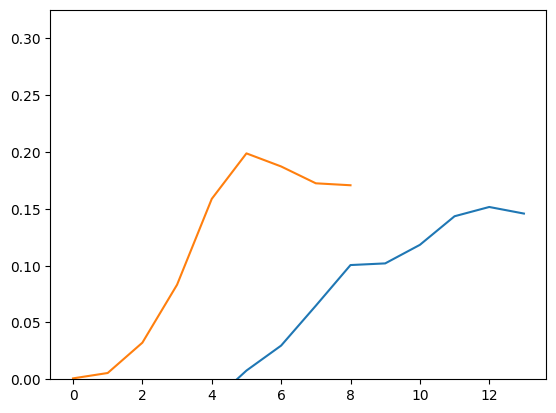

In [144]:
import matplotlib.pyplot as plt

plt.plot(overall_hyp)
plt.plot(overall_euc)
plt.ylim(0)
plt.show()